In [1]:
import os
import logging
from typing import List, Optional, Tuple, Dict
import wandb

import numpy as np
import pandas as pd

import torch

import minari

import nll_to_po.models.dn_policy as Policy
from nll_to_po.training.utils import (
    train_single_policy,
    setup_logger,
    set_seed_everywhere,
)
import nll_to_po.training.loss as L
import nll_to_po.training.reward as R

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=1.5)
sns.set_palette("colorblind")
sns.despine()

logger = logging.getLogger("wandb")
logger.setLevel(logging.ERROR)
os.environ["WANDB_SILENT"] = "true"  # Suppress WandB output

<Figure size 640x480 with 0 Axes>

### Data utils

In [2]:
def generate_data_minari(
    dataset_name: str,
    train_size: float = 0.8,
    data_proportion: float = 1.0,
    batch_size: int = -1,
    test_size: float = 0.1,
) -> Tuple[
    torch.utils.data.DataLoader,
    torch.utils.data.DataLoader,
    torch.utils.data.DataLoader,
    Dict[str, int],
]:
    """Create train/val/test DataLoaders from a Minari dataset.

    Returns: (train_loader, val_loader, test_loader, {input_dim, output_dim})
    """
    assert train_size + test_size <= 1.0, (
        "train_size + test_size must be <= 1.0 (for validation)"
    )

    seed = np.random.randint(0, 1_000_000)
    set_seed_everywhere(seed=int(seed))

    dataset = minari.load_dataset(dataset_name, download=True)
    dataset.set_seed(seed=int(seed))

    observations = []
    actions = []
    next_observations = []
    for episode in dataset:
        observations.append(episode.observations[:-1])
        actions.append(episode.actions)
        next_observations.append(episode.observations[1:])
    observations = np.concatenate(observations, axis=0)
    actions = np.concatenate(actions, axis=0)
    next_observations = np.concatenate(next_observations, axis=0)

    obs_dim = observations.shape[1]
    action_dim = actions.shape[1]

    X = torch.tensor(
        np.concatenate([observations, actions], axis=1), dtype=torch.float32
    )
    y = torch.tensor(next_observations, dtype=torch.float32)

    # Shuffle and select subset
    total_size = len(X)
    indices = torch.randperm(total_size)
    selected_size = int(total_size * data_proportion)
    selected_indices = indices[:selected_size]

    X = X[selected_indices]
    y = y[selected_indices]

    # Train/val/test split
    trn_size = int(len(X) * train_size)
    test_size_actual = int(len(X) * test_size)
    val_size = len(X) - trn_size - test_size_actual

    X_train, X_val, X_test = (
        X[:trn_size],
        X[trn_size : trn_size + val_size],
        X[trn_size + val_size :],
    )
    y_train, y_val, y_test = (
        y[:trn_size],
        y[trn_size : trn_size + val_size],
        y[trn_size + val_size :],
    )

    # using y as mu and sigma zero
    train_dataset = torch.utils.data.TensorDataset(
        X_train, y_train, y_train, torch.zeros_like(y_train)
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size if batch_size > 0 else X_train.shape[0],
        shuffle=True,
    )
    val_dataset = torch.utils.data.TensorDataset(
        X_val, y_val, y_val, torch.zeros_like(y_val)
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size if batch_size > 0 else X_val.shape[0],
        shuffle=False,
    )
    test_dataset = torch.utils.data.TensorDataset(
        X_test, y_test, y_test, torch.zeros_like(y_test)
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size if batch_size > 0 else X_test.shape[0],
        shuffle=False,
    )

    return (
        train_loader,
        val_loader,
        test_loader,
        {
            "input_dim": obs_dim + action_dim,
            "output_dim": obs_dim,
            "dataset_name": "_".join(dataset_name.split("/")),
            "train_size": train_size,
            "data_proportion": data_proportion,
            "batch_size": batch_size,
        },
    )

### Exp function

In [3]:
def run_exp(
    policy: Policy.MLPPolicy,
    loss_function: L.LossFunction,
    train_dataloader: torch.utils.data.DataLoader,
    val_dataloader: Optional[torch.utils.data.DataLoader] = None,
    config: Optional[dict] = None,
    exp_idx: Optional[int] = 0,
    df_list: List = [],
    device: torch.device = torch.device("cpu"),
    early_stopping_patience: int = 20,
    n_updates: int = 300,
    learning_rate: float = 0.01,
    use_wandb: bool = False,
    wandb_project: str = "tractable",
):
    config["train_size"] = len(train_dataloader)
    if val_dataloader is not None:
        config["val_size"] = len(val_dataloader)
    config["loss_type"] = loss_function.name

    if use_wandb:
        wandb_run = wandb.init(
            project=wandb_project,
            config=config,
        )
    else:
        wandb_run = None

    logger, _, ts_writer = setup_logger(
        logger_name="nll_to_po",
        log_dir="../logs",
        env_id="test_theory",
        exp_name=f"{loss_function.name}_{exp_idx}",
    )
    # Log the configuration
    logger.info(f"%%%%%%%%%%%%%%%%%%%\nconfig:\n{config}\n%%%%%%%%%%%%%%%%%%%%")

    # Run comparison
    _, mse_train_metrics, mse_val_metrics, mse_test_metrics, _ = train_single_policy(
        policy=policy,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        loss_function=loss_function,
        n_updates=n_updates,
        learning_rate=learning_rate,
        tensorboard_writer=ts_writer,
        logger=logger,
        wandb_run=wandb_run,
        device=device,
        early_stopping_patience=early_stopping_patience,
    )

    # Save to dataframe
    # train
    df = pd.DataFrame(mse_train_metrics).reset_index()
    df = df.rename(columns={"index": "epoch"})
    for k, v in config.items():
        df[k] = v
    df["experiment"] = exp_idx
    df["train_val"] = "train"
    df_list.append(df)
    # val
    df = pd.DataFrame(mse_val_metrics).reset_index()
    df = df.rename(columns={"index": "epoch"})
    for k, v in config.items():
        df[k] = v
    df["experiment"] = exp_idx
    df["train_val"] = "val"
    df_list.append(df)
    # Test
    df = pd.DataFrame(mse_test_metrics).reset_index()
    df = df.rename(columns={"index": "epoch"})
    for k, v in config.items():
        df[k] = v
    df["experiment"] = exp_idx
    df["train_val"] = "test"
    df_list.append(df)

### Generate data and policy

In [14]:
df_list: list[pd.DataFrame] = []

In [15]:
# Experiment parameters
n_experiments: int = 1
n_updates: int = 50
learning_rate: float = 0.001
use_wandb: bool = False
wandb_project: str = "tractable"

dataset_name: str = "mujoco/halfcheetah/medium-v0"
train_size: float = 0.5
test_size: float = 0.3
data_proportion: float = 0.01
batch_size: int = -1
device = torch.device("cuda:7")
early_stopping_patience: int = 300

train_dataloader, val_dataloader, test_dataloader, data_config = generate_data_minari(
    dataset_name=dataset_name,
    train_size=train_size,
    test_size=test_size,
    data_proportion=data_proportion,
    batch_size=batch_size,
)

# Policy architecture
hidden_sizes: list[int] = [64, 64]
fixed_logstd: bool = False
bounded_sigma: bool = True

# policy = Policy.LinearGaussian(input_dim, output_dim, fixed_logstd)
if bounded_sigma:
    # Compute LOG_VAR_MAX = log(max(obs) - min(obs))
    all_targets = []
    for _, y_batch, _, _ in train_dataloader:
        all_targets.append(y_batch)
    all_targets = torch.cat(all_targets, dim=0)
    obs_min = torch.min(all_targets, dim=0)[0]
    obs_max = torch.max(all_targets, dim=0)[0]
    log_var_max = torch.log(obs_max - obs_min)
    print(f"LOG_VAR_MAX: {log_var_max}")
    policy = Policy.MLPPolicyBounded(
        input_dim=data_config["input_dim"],
        output_dim=data_config["output_dim"],
        hidden_sizes=hidden_sizes,
        fixed_logstd=fixed_logstd,
        log_var_max=log_var_max,
    )
else:
    policy = Policy.MLPPolicy(
        input_dim=data_config["input_dim"],
        output_dim=data_config["output_dim"],
        hidden_sizes=hidden_sizes,
        fixed_logstd=fixed_logstd,
    )

LOG_VAR_MAX: tensor([0.6432, 3.5763, 0.6048, 0.6870, 0.3126, 0.6800, 0.8035, 0.2347, 2.9799,
        2.1110, 2.8506, 3.9128, 4.0208, 3.7924, 4.0341, 4.0300, 3.7786])


### Baselines: MSE & NLL

In [16]:
for loss_function in [L.MSE(), L.NLL()]:
    for exp_idx in range(n_experiments):
        config = {
            "fixed_logstd": fixed_logstd,
            "dataset_name": dataset_name,
            "learning_rate": learning_rate,
        }
        run_exp(
            policy=policy,
            loss_function=loss_function,
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            config=config,
            exp_idx=exp_idx,
            df_list=df_list,
            device=device,
            early_stopping_patience=early_stopping_patience,
            n_updates=n_updates,
            learning_rate=learning_rate,
            use_wandb=use_wandb,
            wandb_project=wandb_project,
        )

2025-08-24 17:13:12 - nll_to_po - INFO - %%%%%%%%%%%%%%%%%%%
config:
{'fixed_logstd': False, 'dataset_name': 'mujoco/halfcheetah/medium-v0', 'learning_rate': 0.001, 'train_size': 1, 'val_size': 1, 'loss_type': 'MSE'}
%%%%%%%%%%%%%%%%%%%%
2025-08-24 17:13:12 - nll_to_po - INFO - Starting training for 50 epochs
Training epochs: 100%|██████████| 50/50 [00:03<00:00, 13.49it/s]
2025-08-24 17:13:15 - nll_to_po - INFO - Training completed after 50 epochs
2025-08-24 17:13:15 - nll_to_po - INFO - %%%%%%%%%%%%%%%%%%%
config:
{'fixed_logstd': False, 'dataset_name': 'mujoco/halfcheetah/medium-v0', 'learning_rate': 0.001, 'train_size': 1, 'val_size': 1, 'loss_type': 'NLL'}
%%%%%%%%%%%%%%%%%%%%
2025-08-24 17:13:15 - nll_to_po - INFO - Starting training for 50 epochs
Training epochs: 100%|██████████| 50/50 [00:03<00:00, 14.31it/s]
2025-08-24 17:13:19 - nll_to_po - INFO - Training completed after 50 epochs


### PG Entropy Reg

#### Estimate tr(Sigma) from training data

In [17]:
# Fit multivariate Gaussian on training data and estimate trace of covariance matrix
y_train = []
for X_batch, y_batch, _, _ in train_dataloader:
    y_train.append(y_batch)

y_train = torch.cat(y_train, dim=0)

# Compute empirical mean and covariance of the target (next observations)
y_mean = torch.mean(y_train, dim=0)
y_centered = y_train - y_mean
covariance_matrix = torch.cov(y_centered.T)

# Compute trace of covariance matrix
trace_sigma = torch.trace(covariance_matrix)

print(f"Empirical mean of targets: {y_mean}")
print(f"Trace of covariance matrix: {trace_sigma:.6f}")
print(f"Covariance matrix shape: {covariance_matrix.shape}")

Empirical mean of targets: tensor([-8.6721e-02,  7.9436e-01,  1.2564e-01, -7.7458e-02,  8.3239e-02,
         1.1287e-01, -1.9348e-02, -2.3783e-02,  1.2573e+01, -2.4617e-02,
        -6.0756e-03,  3.9800e-01, -6.4372e-01, -4.7266e-01,  3.4665e-01,
        -4.6304e-01, -1.5438e-01])
Trace of covariance matrix: 707.475464
Covariance matrix shape: torch.Size([17, 17])


In [ ]:
n_generations: int = 5
use_rsample: bool = False
reward_transform: str = "normalize"

for exp_idx in range(n_experiments):
    for entropy_weight in [0.1, 1.0, 5.0]:
        for r_u in [
            1.0,
            (entropy_weight * data_config["output_dim"]) / trace_sigma,
        ]:
            # Define reward function
            reward_fn = R.Mahalanobis(
                matrix=r_u * torch.eye(data_config["output_dim"]).to(device=device),
            )

            config = {
                "fixed_logstd": fixed_logstd,
                "dataset_name": dataset_name,
                "learning_rate": learning_rate,
                "n_generations": n_generations,
                "use_rsample": use_rsample,
                "reward_transform": reward_transform,
                "entropy_weight": entropy_weight,
                "reward_fn": reward_fn.name,
                "U": r"PG($U=I$)"
                if r_u == 1.0
                else r"PG($U=\frac{\lambda n}{Tr(\Sigma)}I$)",
            }

            # Define the loss function
            loss_function = L.PG(
                reward_fn=reward_fn,
                n_generations=n_generations,
                use_rsample=use_rsample,
                reward_transform=reward_transform,
                entropy_weight=entropy_weight,
            )
            run_exp(
                policy=policy,
                loss_function=loss_function,
                train_dataloader=train_dataloader,
                val_dataloader=val_dataloader,
                config=config,
                exp_idx=exp_idx,
                df_list=df_list,
                device=device,
                early_stopping_patience=early_stopping_patience,
                n_updates=n_updates,
                learning_rate=learning_rate,
                use_wandb=use_wandb,
                wandb_project=wandb_project,
            )

2025-08-24 17:13:22 - nll_to_po - INFO - %%%%%%%%%%%%%%%%%%%
config:
{'fixed_logstd': False, 'dataset_name': 'mujoco/halfcheetah/medium-v0', 'learning_rate': 0.001, 'n_generations': 5, 'use_rsample': False, 'reward_transform': 'normalize', 'entropy_weight': 0.1, 'reward_fn': 'Mahalanobis($I$)', 'U': 'PG($U=I$)', 'train_size': 1, 'val_size': 1, 'loss_type': 'PG(lam=0.1)_Mahalanobis($I$)'}
%%%%%%%%%%%%%%%%%%%%
2025-08-24 17:13:22 - nll_to_po - INFO - Starting training for 300 epochs
Training epochs: 100%|██████████| 300/300 [00:21<00:00, 14.11it/s]
2025-08-24 17:13:43 - nll_to_po - INFO - Training completed after 300 epochs
2025-08-24 17:13:43 - nll_to_po - INFO - %%%%%%%%%%%%%%%%%%%
config:
{'fixed_logstd': False, 'dataset_name': 'mujoco/halfcheetah/medium-v0', 'learning_rate': 0.001, 'n_generations': 5, 'use_rsample': False, 'reward_transform': 'normalize', 'entropy_weight': 0.1, 'reward_fn': 'Mahalanobis($\\frac{\\lambda n}{2 Tr(\\Sigma)}I$)', 'U': 'PG($U=\\frac{\\lambda n}{Tr(\\Sigma

### plot

In [19]:
df_all = pd.concat(df_list, ignore_index=True)
df_all.head(3)

,epoch,mean_error,loss,grad_norm,fixed_logstd,dataset_name,learning_rate,train_size,val_size,loss_type,...,NLL,sigma_error,entropy,reward_mean,n_generations,use_rsample,reward_transform,entropy_weight,reward_fn,U
0,0,7.139335,50.970108,15.639334,False,mujoco/halfcheetah/medium-v0,0.001,1,1,MSE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,7.100700,50.419949,15.242411,False,mujoco/halfcheetah/medium-v0,0.001,1,1,MSE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,7.063070,49.886959,14.998771,False,mujoco/halfcheetah/medium-v0,0.001,1,1,MSE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


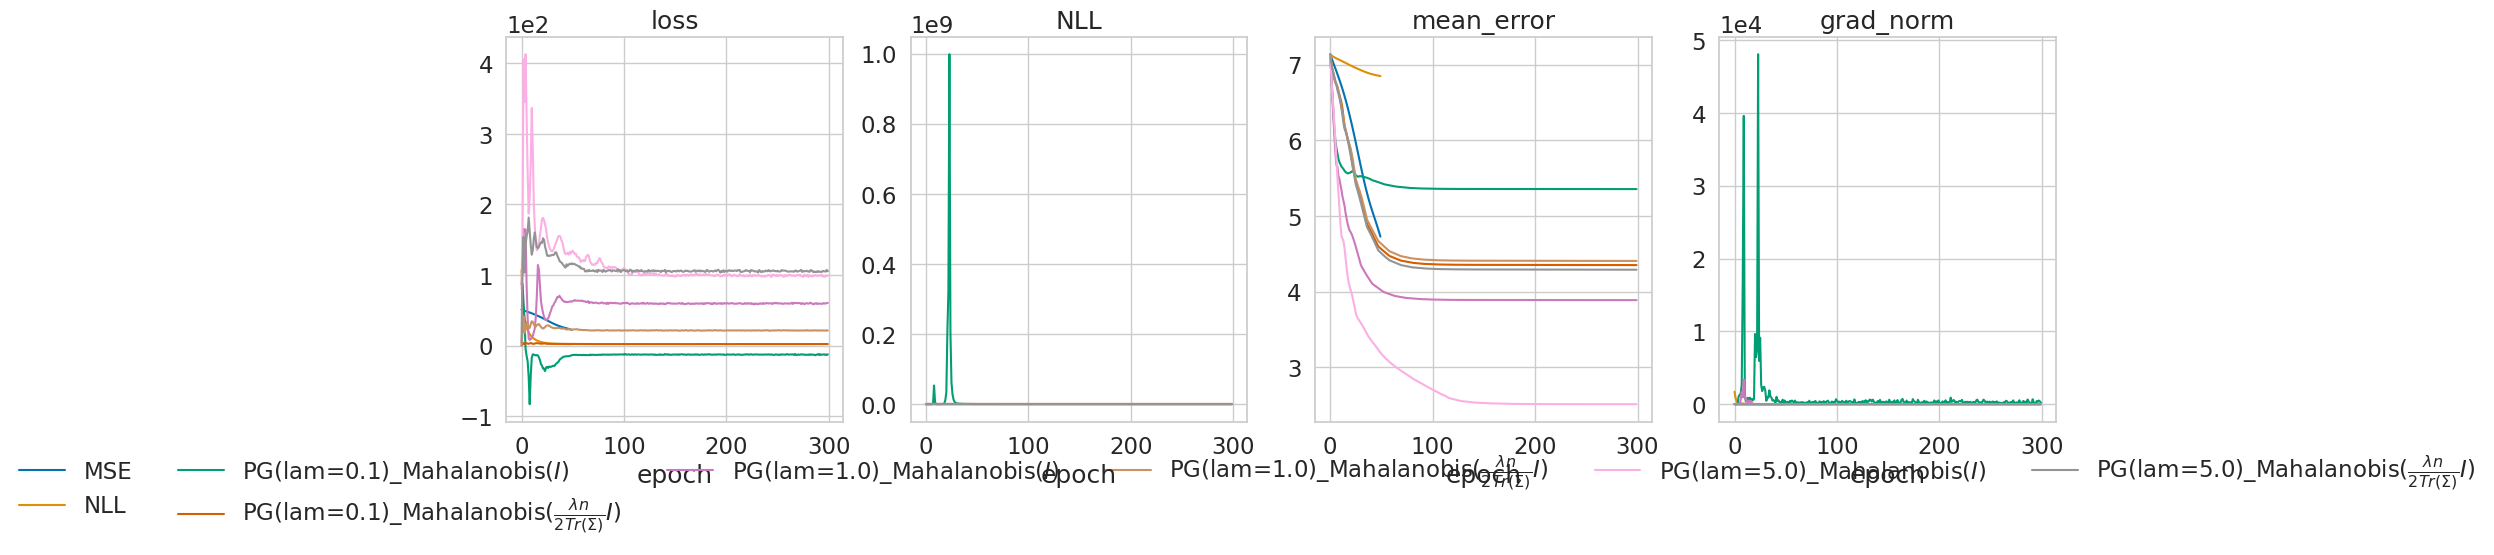

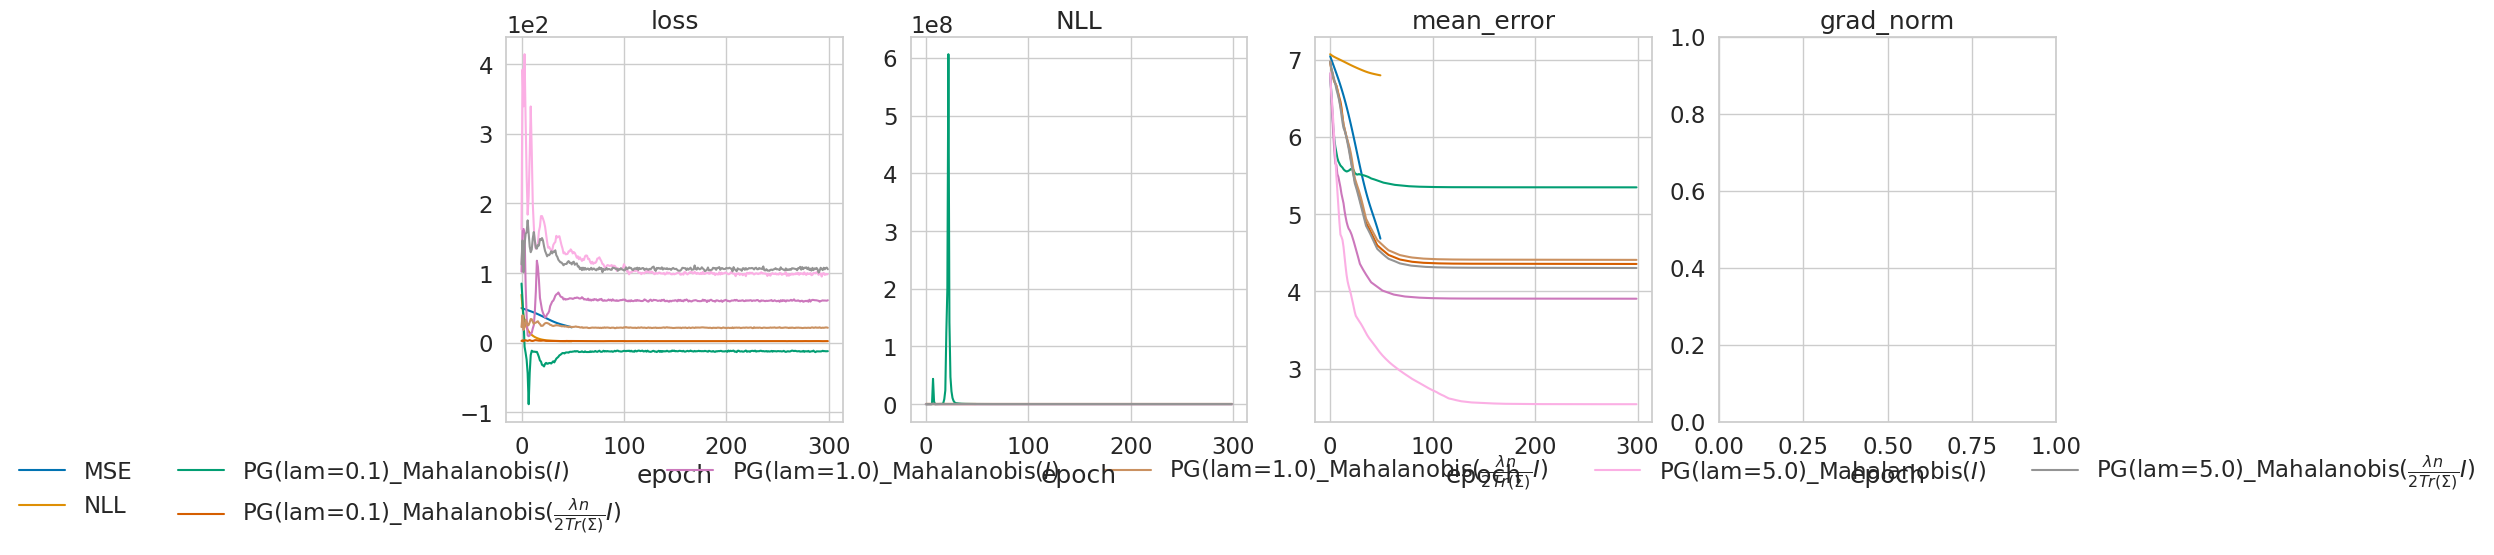

In [20]:
# train
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i, metric in enumerate(["loss", "NLL", "mean_error", "grad_norm"]):
    sns.lineplot(
        data=df_all[df_all["train_val"] == "train"],
        x="epoch",
        y=metric,
        hue="loss_type",
        ax=ax[i],
        legend=False if i > 0 else True,
    )
    ax[i].set_ylabel(None)
    ax[i].set_title(metric)
    ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0, 1))
ax[0].legend(bbox_to_anchor=(2.2, -0.35), loc="lower center", ncol=6, frameon=False)

# validation
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i, metric in enumerate(["loss", "NLL", "mean_error", "grad_norm"]):
    sns.lineplot(
        data=df_all[df_all["train_val"] == "val"],
        x="epoch",
        y=metric,
        hue="loss_type",
        ax=ax[i],
        legend=False if i > 0 else True,
    )
    ax[i].set_ylabel(None)
    ax[i].set_title(metric)
    ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0, 1))
ax[0].legend(bbox_to_anchor=(2.2, -0.35), loc="lower center", ncol=6, frameon=False)
plt.show()

### ablations

In [18]:
def plot_ablation(
    df: pd.DataFrame,
    hue_variable: str,
    style_variable: Optional[str] = None,
    loss_type_list: List[str] = [],
    use_rsample_list: List[bool] = [],
    n_generations_list: List[int] = [],
    entropy_weight_list: List[float] = [],
    reward_transform_list: List[str] = [],
):
    sub_df = df.copy()
    if loss_type_list:
        sub_df = sub_df[sub_df["loss_type"].isin(loss_type_list)]
    if use_rsample_list:
        sub_df = sub_df[sub_df["use_rsample"].isin(use_rsample_list)]
    if n_generations_list:
        sub_df = sub_df[sub_df["n_generations"].isin(n_generations_list)]
    if entropy_weight_list:
        sub_df = sub_df[sub_df["entropy_weight"].isin(entropy_weight_list)]
    if reward_transform_list:
        sub_df = sub_df[sub_df["reward_transform"].isin(reward_transform_list)]

    sub_df["entropy_weight"] = sub_df["entropy_weight"].astype("str")

    _, ax = plt.subplots(1, 4, figsize=(16, 5))
    for i, metric in enumerate(["loss", "NLL", "mean_error", "grad_norm"]):
        sns.lineplot(
            data=sub_df[sub_df["train_val"] == "train"],
            x="epoch",
            y=metric,
            hue=hue_variable,
            style=style_variable,
            ax=ax[i],
            legend=False if i > 0 else True,
        )
        ax[i].set_ylabel(None)
        ax[i].set_title(metric)
        ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0, 1))
    ax[0].legend(bbox_to_anchor=(2.5, -0.55), loc="lower center", ncol=4, frameon=False)

    _, ax = plt.subplots(1, 4, figsize=(16, 5))
    for i, metric in enumerate(["loss", "NLL", "mean_error", "grad_norm"]):
        sns.lineplot(
            data=sub_df[sub_df["train_val"] == "val"],
            x="epoch",
            y=metric,
            hue=hue_variable,
            style=style_variable,
            ax=ax[i],
            legend=False if i > 0 else True,
        )
        ax[i].set_ylabel(None)
        ax[i].set_title(metric)
        ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0, 1))
    ax[0].legend(bbox_to_anchor=(2.5, -0.55), loc="lower center", ncol=6, frameon=False)
    plt.show()

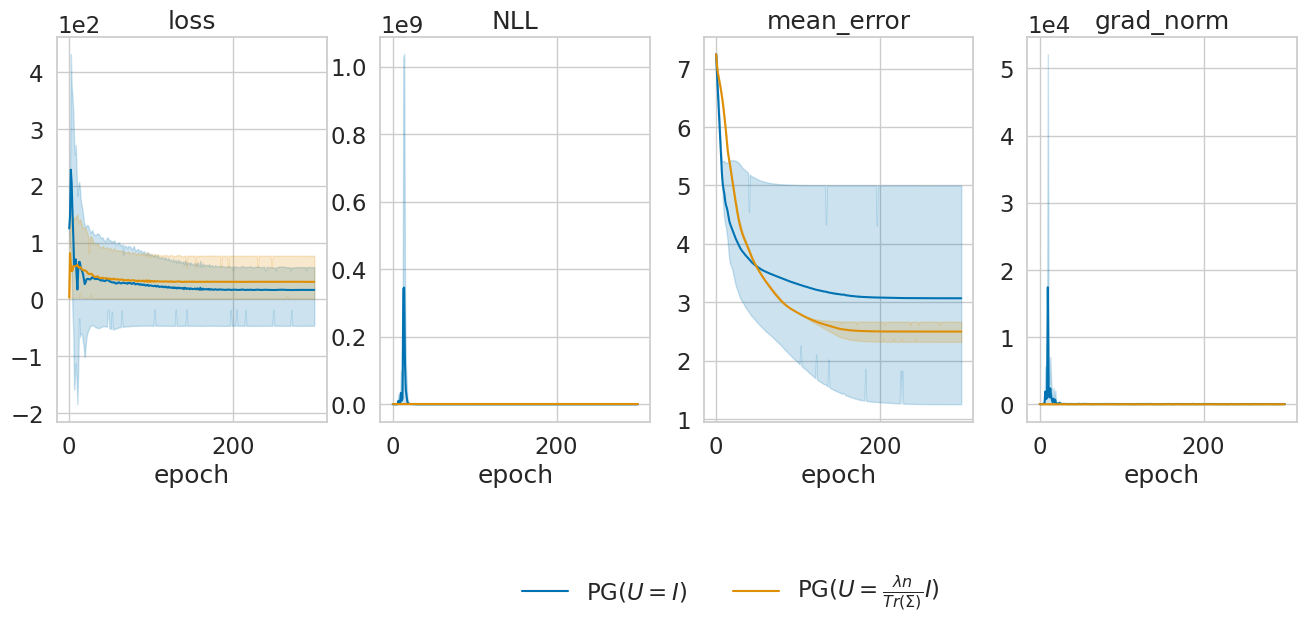

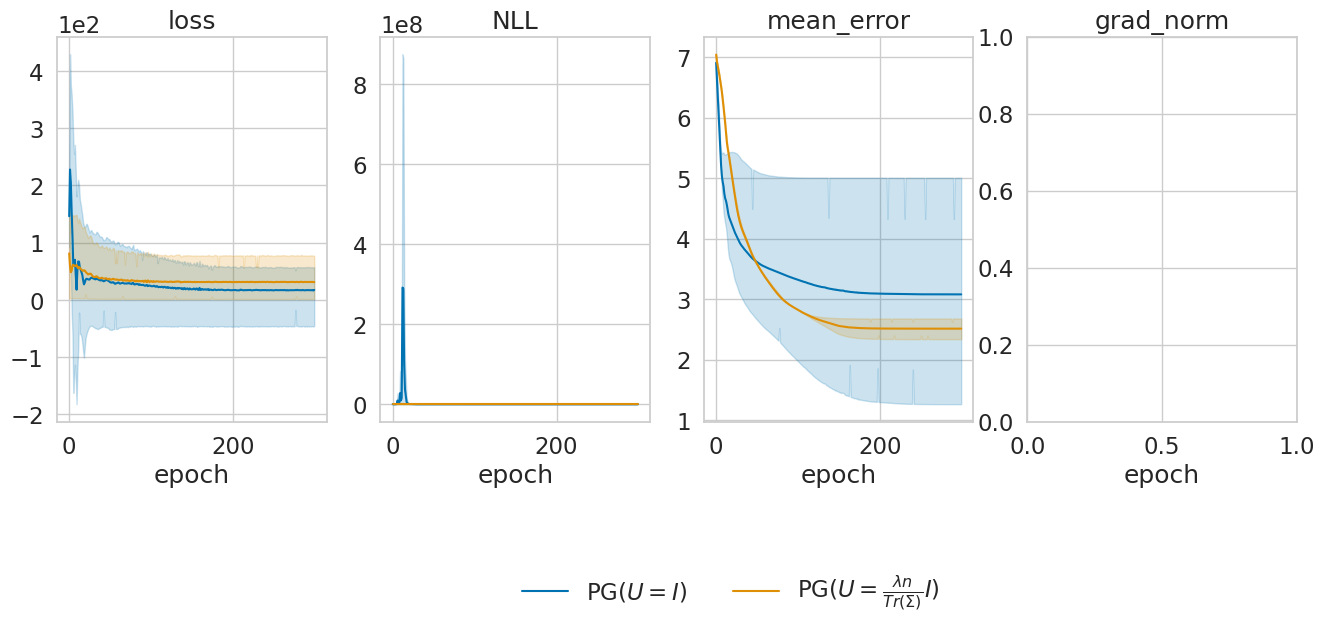

In [19]:
plot_ablation(
    df=df_all,
    hue_variable="U",
    style_variable=None,
    loss_type_list=[],
    use_rsample_list=[],
    n_generations_list=[],
    entropy_weight_list=[],
    reward_transform_list=[],
)

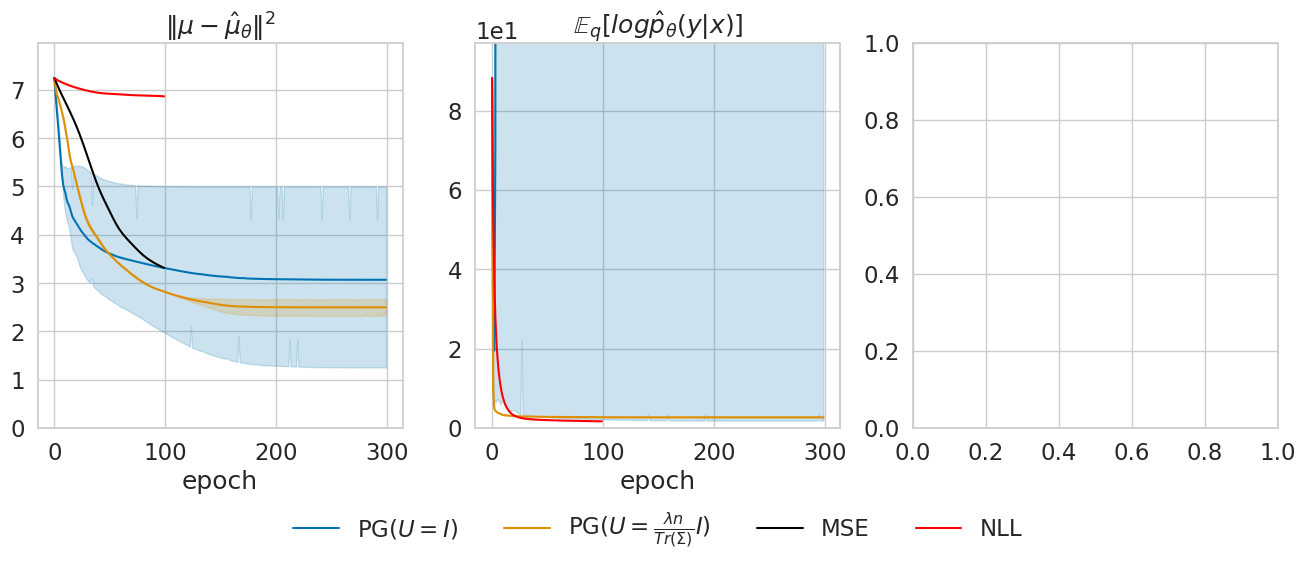

In [20]:
sub_df = df_all.copy()
sub_df["entropy_weight"] = sub_df["entropy_weight"].astype("str")
sub_df = sub_df[sub_df["train_val"] == "train"]

metric_name = []
metric_name.append(("mean_error", r"$\|\mu-\hat{\mu}_\theta\|^2$"))
metric_name.append(("NLL", r"$\mathbb{E}_q[log\hat{p}_\theta(y|x)]$"))
# metric_name.append(("std_error", r"$\|\sigma-\hat{\sigma}_\theta\|^2$"))

_, ax = plt.subplots(1, 3, figsize=(16, 5))
for i, (metric, name) in enumerate(metric_name):
    sns.lineplot(
        data=sub_df.dropna(subset=["U"]),
        x="epoch",
        y=metric,
        hue="U",  # "entropy_weight",
        # style="U",
        ax=ax[i],
        legend=False if i > 0 else True,
    )
    if metric == "mean_error":
        sns.lineplot(
            data=sub_df[sub_df["loss_type"] == "MSE"],
            x="epoch",
            y=metric,
            ax=ax[i],
            color="black",
            label="MSE",
        )
    sns.lineplot(
        data=sub_df[sub_df["loss_type"] == "NLL"],
        x="epoch",
        y=metric,
        ax=ax[i],
        color="red",
        label="NLL" if i == 0 else None,
    )
    max_for_lim = sub_df[(sub_df["loss_type"] == "NLL")][metric].max()
    ax[i].set_ylim(
        min(sub_df[(sub_df["loss_type"] == "NLL")][metric].min(), 0.0),
        max_for_lim + 0.1 * max_for_lim,
    )
    ax[i].set_ylabel(None)
    ax[i].set_title(name)
    ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0, 1))
ax[0].legend(bbox_to_anchor=(1.7, -0.37), loc="lower center", ncol=4, frameon=False)
# ax[0].legend(bbox_to_anchor=(1.73, 1.03))
# plt.savefig("../figures/toy_avg.pdf", bbox_inches="tight")
plt.show()

/tmp/ipykernel_3006128/2470899165.py:100: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[2, 1].legend(bbox_to_anchor=(1.1, -0.21), loc="lower center", ncol=4, frameon=False)


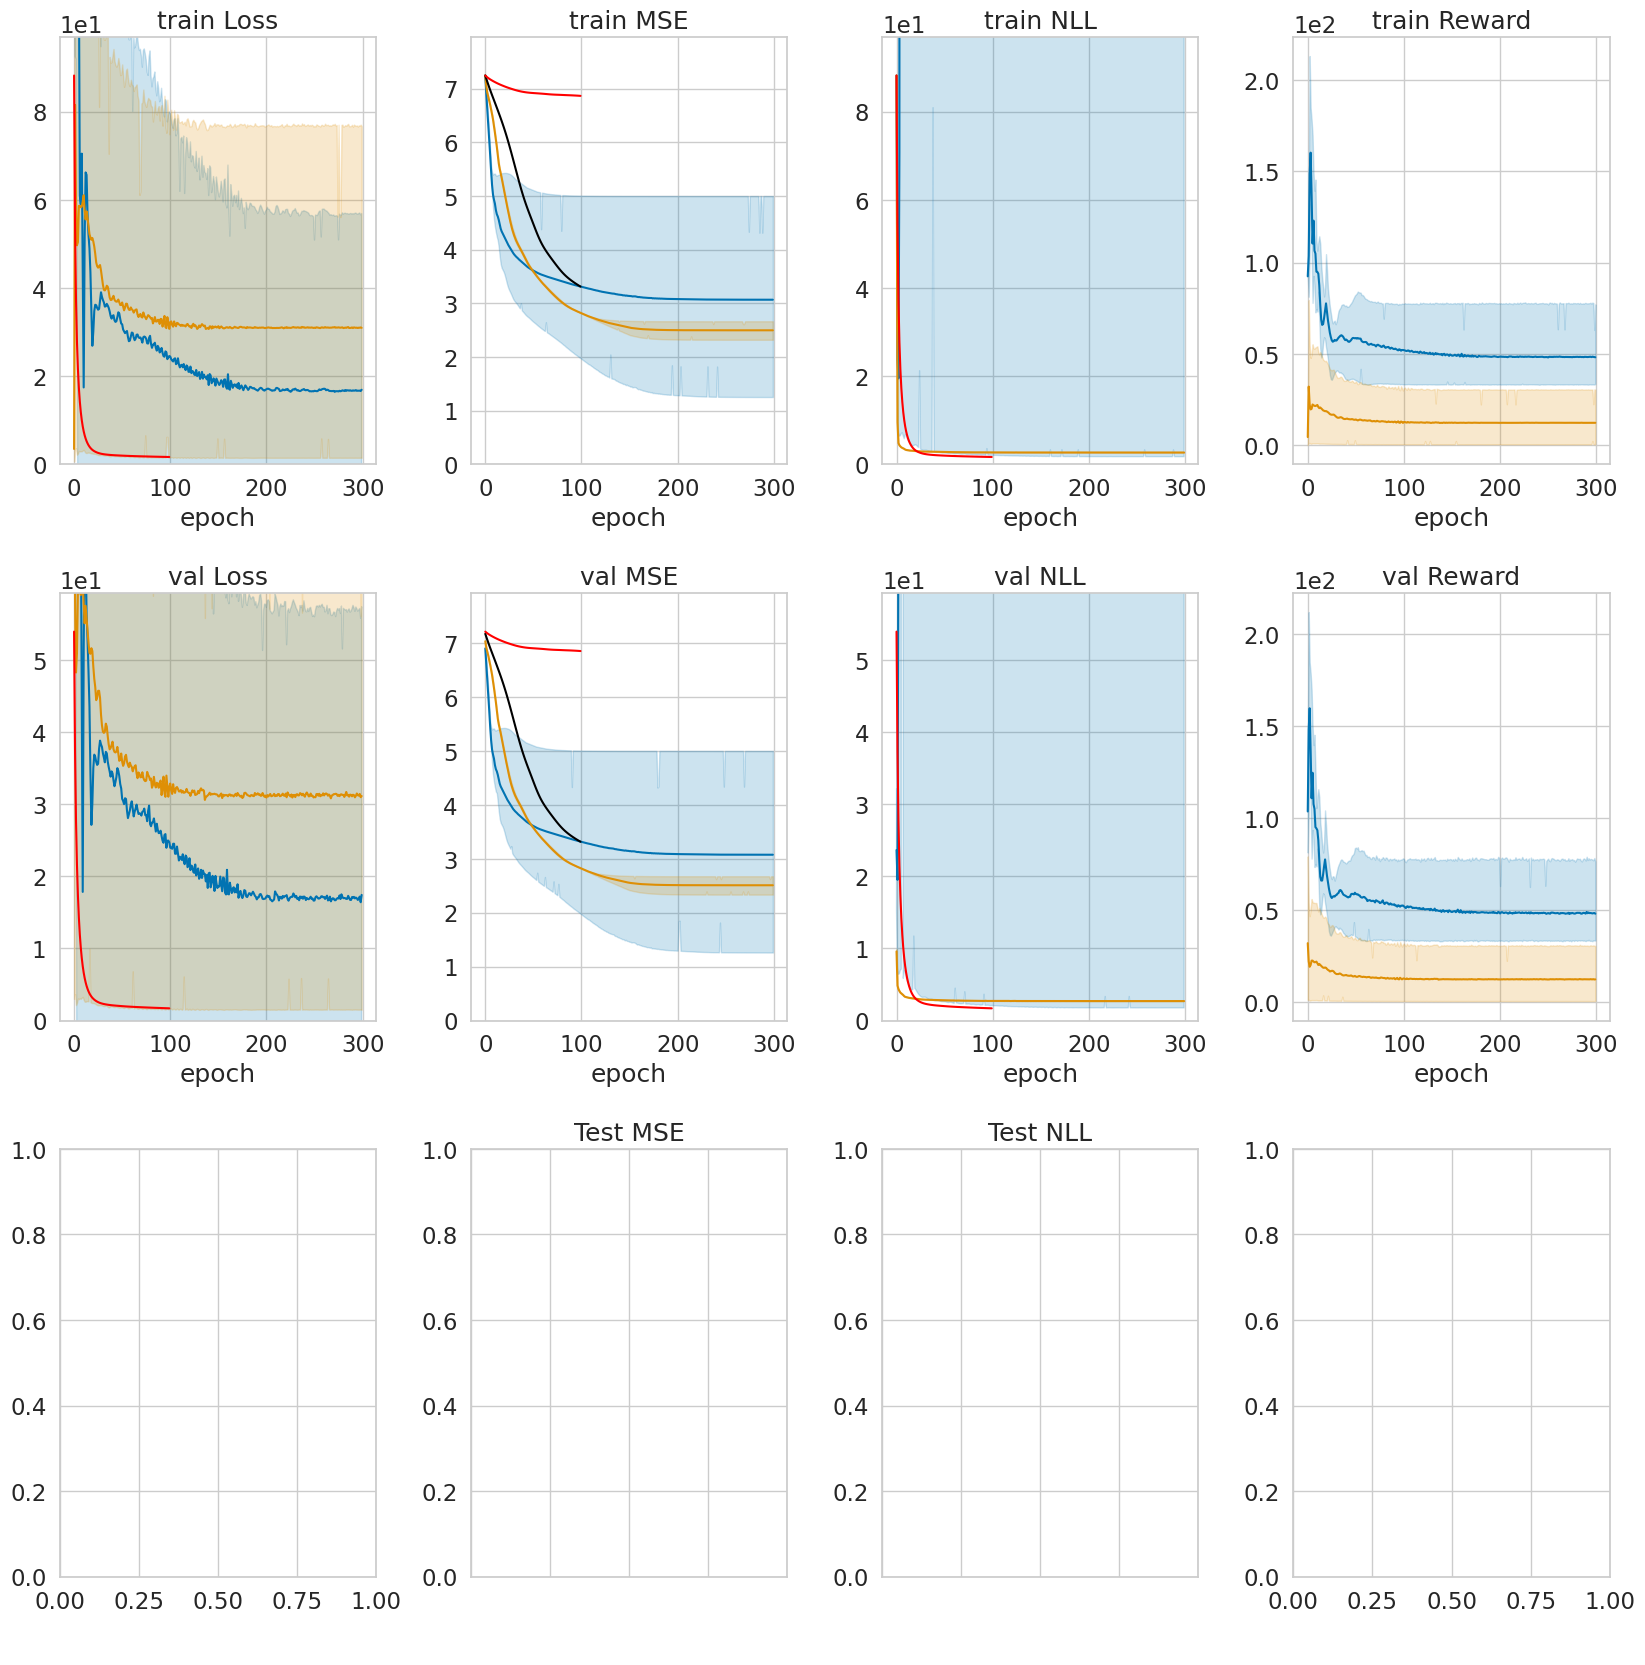

In [ ]:
df = df_all.copy()
df["entropy_weight"] = df["entropy_weight"].astype("str")

metric_name = []
metric_name.append(("loss", "Loss"))
# metric_name.append(("mean_error", r"$\|\mu-\hat{\mu}_\theta\|^2$"))
metric_name.append(("mean_error", "MSE"))
# metric_name.append(("NLL", r"$\mathbb{E}_q[log\hat{p}_\theta(y|x)]$"))
metric_name.append(("NLL", "NLL"))
# metric_name.append(("std_error", r"$\|\sigma-\hat{\sigma}_\theta\|^2$"))
metric_name.append(("reward_mean", "Reward"))
# metric_name.append(("grad_norm", "Gradient norm"))

_, ax = plt.subplots(
    3, len(metric_name), figsize=(20, 15), gridspec_kw=dict(hspace=0.3, wspace=0.3)
)

# Train / Val
for tr_val_idx, train_val in enumerate(["train", "val"]):
    sub_df = df[df["train_val"] == train_val].copy()
    for i, (metric, name) in enumerate(metric_name):
        sns.lineplot(
            data=sub_df.dropna(subset=["U"]),
            x="epoch",
            y=metric,
            hue="U",  # "entropy_weight",
            # style="U",
            ax=ax[tr_val_idx, i],
            legend=False,
        )
        if metric == "mean_error":
            sns.lineplot(
                data=sub_df[sub_df["loss_type"] == "MSE"],
                x="epoch",
                y=metric,
                ax=ax[tr_val_idx, i],
                color="black",
                legend=False,
            )
        if metric not in ["reward_mean"]:
            sns.lineplot(
                data=sub_df[sub_df["loss_type"] == "NLL"],
                x="epoch",
                y=metric,
                ax=ax[tr_val_idx, i],
                color="red",
                legend=False,
            )
            max_for_lim = sub_df[(sub_df["loss_type"] == "NLL")][metric].max()
            ax[tr_val_idx, i].set_ylim(
                min(sub_df[(sub_df["loss_type"] == "NLL")][metric].min(), 0.0),
                max_for_lim + 0.1 * max_for_lim,
            )
        ax[tr_val_idx, i].set_ylabel(None)
        ax[tr_val_idx, i].set_title(f"{train_val} {name}")
        ax[tr_val_idx, i].ticklabel_format(axis="y", style="sci", scilimits=(0, 1))

# Test
sub_df = df[df["train_val"] == "test"].copy()
for i, (metric, name) in enumerate(metric_name):
    if metric in ["loss", "reward_mean"]:
        continue
    sns.boxplot(
        data=sub_df.dropna(subset=["U"]),
        x="U",
        y=metric,
        hue="U",  # "entropy_weight",
        # style="U",
        ax=ax[2, i],
        legend=False if i != 1 else True,
    )
    if metric == "mean_error":
        sns.boxplot(
            data=sub_df[sub_df["loss_type"] == "MSE"],
            x="loss_type",
            y=metric,
            ax=ax[2, i],
            color="black",
            label="MSE",
        )
    sns.boxplot(
        data=sub_df[sub_df["loss_type"] == "NLL"],
        x="loss_type",
        y=metric,
        ax=ax[2, i],
        color="red",
        label=None if i != 1 else "NLL",
    )
    # max_for_lim = sub_df[(sub_df["loss_type"] == "NLL")][metric].max()
    # ax[i].set_ylim(
    #     min(sub_df[(sub_df["loss_type"] == "NLL")][metric].min(), 0.0),
    #     max_for_lim + 0.1 * max_for_lim,
    # )
    ax[2, i].set_ylabel(None)
    ax[2, i].set_xlabel(None)
    ax[2, i].set_xticklabels([])
    ax[2, i].set_title(f"Test {name}")
    ax[2, i].ticklabel_format(axis="y", style="sci", scilimits=(0, 1))

ax[2, 1].legend(bbox_to_anchor=(1.1, -0.21), loc="lower center", ncol=4, frameon=False)
# ax[0].legend(bbox_to_anchor=(1.73, 1.03))
# plt.savefig("../figures/toy_avg.pdf", bbox_inches="tight")
plt.show()